# Face Recognition Using LDA(Linear Discriminant Analysis)

##1. Dataset Upload and Extract

### 1.1 Dataset Upload

In [1]:
# import dataset
from google.colab import files
uploaded = files.upload()

Saving att_faces_ORG.zip to att_faces_ORG.zip


### 1.2 Dataset Extract

In [2]:
!unzip att_faces_ORG.zip

Archive:  att_faces_ORG.zip
   creating: att_faces/
  inflating: att_faces/README        
   creating: att_faces/s1/
   creating: att_faces/s10/
  inflating: att_faces/s10/1.pgm     
  inflating: att_faces/s10/10.pgm    
  inflating: att_faces/s10/2.pgm     
  inflating: att_faces/s10/3.pgm     
  inflating: att_faces/s10/4.pgm     
  inflating: att_faces/s10/5.pgm     
  inflating: att_faces/s10/6.pgm     
  inflating: att_faces/s10/7.pgm     
  inflating: att_faces/s10/8.pgm     
  inflating: att_faces/s10/9.pgm     
   creating: att_faces/s11/
  inflating: att_faces/s11/1.pgm     
  inflating: att_faces/s11/10.pgm    
  inflating: att_faces/s11/2.pgm     
  inflating: att_faces/s11/3.pgm     
  inflating: att_faces/s11/4.pgm     
  inflating: att_faces/s11/5.pgm     
  inflating: att_faces/s11/6.pgm     
  inflating: att_faces/s11/7.pgm     
  inflating: att_faces/s11/8.pgm     
  inflating: att_faces/s11/9.pgm     
   creating: att_faces/s12/
  inflating: att_faces/s12/1.pgm     
 

### 1.3 Verify the Dataset
Verify if our datasets are correclty imported

In [3]:
# to chack the datasets are correctly uploaded and labeled.
import os
print(os.listdir(os.getcwd()))

['.config', 'att_faces_ORG.zip', 'att_faces', 'sample_data']


## 2. Import of All Required Libraries 

In [4]:
# import required libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2

##3. Steps For Training Dataseet

### 3.1 Generating Face Dataset
Each face image is represented in the form a matrix having m rows and n columns,
where each pixel (x,y) such that xm, and yn shows pixel location of the image as
well as the direction.
For the simplicity we are assuming each face image as a column vector, if we have p
images then the size of the face database will be mn*p.<br>
Let’s say face database is denoted as $(Face Db)_{mn*p}$*italicized text*

In [5]:
Face_db = np.zeros(shape=(400, 112*92)) # image input in p*mn format
y = np.zeros(shape=(400, 1), dtype=np.int8) # name of the corresponding image
p = 0; # increment operator to store each data
for i in range(40):
  images = os.listdir('./att_faces/s'+str(i+1)) # retrive every folder of my path
  for image in images:
    img = cv2.imread('./att_faces/s'+str(i+1)+"/"+image, cv2.IMREAD_GRAYSCALE) # read the input image
    img = np.array(img, dtype=np.float64)
    Face_db[p, :] = img.flatten() # flat the image as mentioned in document
    y[p] = i+1 # label for the input data image
    p += 1 
print(Face_db.shape)
print(y.shape)

(400, 10304)
(400, 1)


###3.2 Perform Split of Data for Training and Testing Purpose
split the 80% of data for training and remaining for testing.

In [6]:
def split(X, y, train_size):
  X_train = []
  X_test = []
  y_train = []
  y_test = []
  for i in range(0, X.shape[0], 10):
    for j in range(10):
      # print(i+j)
      if (j < int(train_size*10)):
        X_train.append(X[i+j, :])
        y_train.append(y[i+j])
      else:
        X_test.append(X[i+j, :])
        y_test.append(y[i+j])
  return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [7]:
train_size = 0.6
X_train, X_test, y_train, y_test = split(Face_db, y, train_size) # spliting by 80%
print(X_train.shape)
y_train.shape;
X_test.shape;
y_test.shape

(240, 10304)


(160, 1)

In [8]:
X_train = X_train.T # to convert data to required format i.e mn*p
X_test = X_test.T
X_test.shape

(10304, 160)

###3.3 Calculate Mean
Calculate the mean of each observation<br>
Here mean vector will have the dimension of $(M)_{mn*1}$

In [9]:
mean = np.mean(X_train, axis=1)
mean = mean.reshape(mean.shape[0], 1) # convert pre ccalculated shape of (mn,) to (mn,1)
print(mean.shape)

(10304, 1)


###3.4 Calculate Deviation Matrix
Subtract mean face from each face image, let’s say this mean zero face data as dev.

In [10]:
dev = X_train-mean
print(dev)
print(dev.shape)

[[-46.98333333 -43.98333333 -44.98333333 ...  41.01666667  39.01666667
   39.01666667]
 [-41.8625     -44.8625     -38.8625     ...  45.1375      38.1375
   33.1375    ]
 [-33.54583333 -42.54583333 -39.54583333 ...  41.45416667  37.45416667
   37.45416667]
 ...
 [-49.05833333 -36.05833333 -43.05833333 ...  15.94166667 -42.05833333
  -42.05833333]
 [-51.1375     -34.1375     -40.1375     ...   6.8625     -42.1375
  -38.1375    ]
 [-47.60833333 -35.60833333 -38.60833333 ...  12.39166667 -42.60833333
  -36.60833333]]
(10304, 240)


###3.5 Calculate Co-Variance of the Mean aligned faces 
Hence here will get covariance matrix of p * p dimension, which is easy to compute and process, the
idea behind computing the surrogate covariance suggested by turk and peterland that,
these are only the valid direction where we will get maximum variances, and rest of the
directions are insignificant to us. Menas these are direction where we will get the
eigenvalues and for rest we will get eigenvalues equal to zero.<br>So, take two column matrix and do vector dot prodect to get a scalar and store that in cov matrix.

In [11]:
# cov = np.zeros(shape=(320, 320))
# for i in range(320):
#   for j in range(320):
#     cov[i, j] = np.dot(dev[:, i], dev[:, j])
# print(cov)
cov = np.dot(dev.T, dev) # calculating covariance matrix by above method
                        # without using any explicit for loops
                        # shape=p*p
print(cov.shape)

(240, 240)


###3.6 Eigenvalue and Eigenvector Decomposition
Determine eigenvalue and eigenvector and  select the best direction from p directions, for this sort the eigenvalues in the
descending order.

In [12]:
lambd, V = np.linalg.eig(cov) # lambd is eigenValue and V is eigenVector
idx = np.argsort(lambd)[::-1] # get the indices in descending order according to data
lambd = lambd[idx] # sort the value
V = V[:, idx] # sort the vector
V.shape

(240, 240)

###3.7 Selection of Prominent Features
decide a k value, which represents the number of selected
eigenvectors to extract k direction from all p direction. On the basis of k value we can
generate the $Feature vector_{p*k}$

In [13]:
def n_components(k, V):
  # choosing n-components, k
  # V is eigenVector
  # return k prominent feature i.e our feature vector
  return V[:, :k]

In [14]:
# testing if above method works fine
feature_vec = n_components(20, V)
print(feature_vec.shape)

(240, 20)


###3.8 Generating Eigenfaces:
For generating the eigenfaces project the each mean aligned face to the generated feature vector
**$(eigenfaces)_{k*mn}$ = $(featureVector)^{T}_{k*p}$ * $(dev)^{T}_{p*mn}$ **

In [15]:
# projecting each mean aligned face and storing of shape k*mn
def gen_eigenface(feature_vec, dev):
  # feature_vec: Feature Vector generated using n-components
  # dev: Deviation matrix
  # Return: EigenFace
  return np.dot(feature_vec.T, dev.T)

In [16]:
# testing if above method works fine
eigen_faces = gen_eigenface(feature_vec, dev) 
eigen_faces.shape

(20, 10304)

###3.10 Generating Projection of Each Train Dataset 

In [17]:
def gen_projection(eigen_faces, dev):
  # eigen_faces: Eigen Face 
  # dev: Deviation matrix
  # Return: projection of dataset
  return np.dot(eigen_faces, dev)

In [18]:
projection_train = gen_projection(eigen_faces, dev) # shape k*p
projection_train.shape

(20, 240)

### 3.10  mean of the Projected faces 

In [19]:
def mean_proj(projection_train):
  M = np.mean(projection_train, axis=1).reshape(-1, 1)
  print("shape of mean of projection", M.shape)
  return M

In [20]:
# checck for implementation
M = mean_proj(projection_train)

shape of mean of projection (20, 1)


###3.11 Intra Class scatter Matrix

In [21]:
def intra_scatter(projection_train):
  SW = np.zeros(shape=(projection_train.shape[0], projection_train.shape[0]))

  for i in range(40): # 40 number of class
    idx = i * int(train_size*10)
    V = projection_train[:, idx:idx+int(train_size*10)]
    mean_local = np.mean(V, axis=1).reshape(-1, 1)
    class_mean = np.repeat(mean_local, int(train_size*10), axis = 1)
    diff = V - class_mean
    variance = np.dot(diff, diff.T)
    SW = SW + variance
  return SW 

In [22]:
SW = intra_scatter(projection_train)
print(SW.shape)

(20, 20)


###3.12 Inter Class scatter Matrix

In [23]:
def inter_scatter(projection_train, M):
  SB = np.zeros(shape=(projection_train.shape[0], projection_train.shape[0]))

  for i in range(40): # 40 number of class
    idx = i + int(train_size*10)
    V = projection_train[:, i:idx]
    mean_local = np.mean(V, axis=1).reshape(-1, 1)
    diff = mean_local - M
    sigma = np.dot(diff, mean_local.T)
    SB = SB + sigma
  return SB 

In [24]:
SB = inter_scatter(projection_train, M)
print(SB.shape)

(20, 20)


###3.13 Criterion Function

In [25]:
def criterion_func(SW, SB):
  return np.dot(np.linalg.pinv(SW), SB)

In [26]:
J = criterion_func(SW, SB)
print(J.shape)

(20, 20)


In [27]:
eigVal, eigVec = np.linalg.eig(J)
idx = np.argsort(eigVal)[::-1] # get the indices in descending order according to data
eigVal = eigVal[idx] # sort the value
eigVec = eigVec[:, idx] # sort the vector
eigVec.shape

(20, 20)

### 3.14 Fisher Face Generation

In [28]:
def fisher_face(eigenVec, projection_train):
  return np.dot(eigenVec.T, projection_train)

In [29]:
fisher_faces = fisher_face(eigVec, projection_train)
print(fisher_faces.shape)

(20, 240)


## 4. Testing Steps

### 4.1 Visualize the test set

In [30]:
print(X_test)
print(X_test.shape)

[[ 64.  43.  48. ... 123. 119. 130.]
 [ 76.  50.  49. ... 121. 121. 123.]
 [ 80.  41.  45. ... 126. 123. 127.]
 ...
 [ 35. 158.  47. ...  40.  36.  33.]
 [ 37. 153.  46. ...  35.  40.  37.]
 [ 39. 169.  46. ...  42.  36.  40.]]
(10304, 160)


### 4.2 DEviation of test set

In [31]:
dev_test = X_test - mean # shape mn*p
print(dev_test.shape)

(10304, 160)


###4.3 Project data of test set for eigen Face
Calculate the projected Eigen Face (PEF) by Project it with the Eigen faces (EF) that we
have constructed by using PCA.

In [32]:
projection = gen_projection(eigen_faces, dev_test) # project each data of test dataset, shape=k*mn
print(projection.shape)

(20, 160)


###4.4 Eucledian Distance Calculation

In [33]:
def euclidean(a, b):
  return np.sqrt(np.sum(np.power((a-b), 2)))

###4.5 Mahalanobis Distance Calculation

###4.6 Projected Fisher Test Image(PFTI)
 Now do the final projection (Projected Fisher Test Image) with the help of feature
vectors (W to this Projected Eigen Face

In [34]:
PFTI = np.dot(eigVec.T, projection)
print(PFTI.shape)

(20, 160)


###4.7 Method for calculating closest match

In [35]:
def predict(d, X):
  # d: projection of testing images
  minDist = np.finfo('float').max # initialize with max value
  minClass = -1 # default closest match initialized
  
  for i in range(X.shape[1]):
    dist = euclidean(X[:, i], d)
    if dist < minDist:
      minDist = dist
      minClass = y_train[i]
  return minClass

In [36]:
correctlyLabeled = 0
for i in range(PFTI.shape[1]):
  predicted = predict(PFTI[:, i], fisher_faces)
  if(predicted == y_test[i]):
    correctlyLabeled += 1
  print("predicted: ", predicted, "correct: ", y_test[i])
accuracy = (correctlyLabeled/projection.shape[1])*100
accuracy

predicted:  [1] correct:  [1]
predicted:  [5] correct:  [1]
predicted:  [1] correct:  [1]
predicted:  [1] correct:  [1]
predicted:  [2] correct:  [2]
predicted:  [2] correct:  [2]
predicted:  [2] correct:  [2]
predicted:  [2] correct:  [2]
predicted:  [3] correct:  [3]
predicted:  [3] correct:  [3]
predicted:  [3] correct:  [3]
predicted:  [3] correct:  [3]
predicted:  [4] correct:  [4]
predicted:  [4] correct:  [4]
predicted:  [4] correct:  [4]
predicted:  [4] correct:  [4]
predicted:  [5] correct:  [5]
predicted:  [5] correct:  [5]
predicted:  [5] correct:  [5]
predicted:  [5] correct:  [5]
predicted:  [6] correct:  [6]
predicted:  [6] correct:  [6]
predicted:  [6] correct:  [6]
predicted:  [6] correct:  [6]
predicted:  [7] correct:  [7]
predicted:  [7] correct:  [7]
predicted:  [7] correct:  [7]
predicted:  [7] correct:  [7]
predicted:  [8] correct:  [8]
predicted:  [8] correct:  [8]
predicted:  [8] correct:  [8]
predicted:  [8] correct:  [8]
predicted:  [9] correct:  [9]
predicted:

92.5

##5. Check for different K Value using LDA

In [37]:
accuracy = []
K = []
for i in range(2, 82, 20):
  K.append(i)
K

[2, 22, 42, 62]

In [38]:
for k in K:
  # print(k)
  feature_vec = n_components(k, V)
  # print("feature_vec", feature_vec.shape)
  eigenFace_train = gen_eigenface(feature_vec, dev)
  # print(eigenFace_train.shape)
  projection_train = gen_projection(eigenFace_train, dev)
  # print(projection_train.shape)
  M = mean_proj(projection_train)
  # print(M.shape)
  SW = intra_scatter(projection_train)
  # print(SW.shape)
  SB = inter_scatter(projection_train, M)
  # print(SB.shape)
  J = criterion_func(SW, SB)
  # print(J.shape)
  eigVal, eigVec = np.linalg.eig(J)
  idx = np.argsort(eigVal)[::-1] # get the indices in descending order according to data
  eigVal = eigVal[idx] # sort the value
  eigVec = eigVec[:, idx] # sort the vector
  # print(eigVec.shape)
  fisher_faces = fisher_face(eigVec, projection_train)
  # print(fisher_faces.shape)
  projection_test = gen_projection(eigenFace_train, dev_test)
  # print(projection_test.shape)
  PFTI = np.dot(eigVec.T, projection_test)
  # print(PFTI.shape)
  correctlMatch = 0
  for i in range(PFTI.shape[1]):
    predicted = predict(PFTI[:, i], fisher_faces)
    if(predicted == y_test[i]):
      correctlMatch += 1
  accuracy.append(correctlMatch/projection_test.shape[1])
print(accuracy)

shape of mean of projection (2, 1)
shape of mean of projection (22, 1)
shape of mean of projection (42, 1)
shape of mean of projection (62, 1)
[0.4125, 0.93125, 0.95, 0.9375]


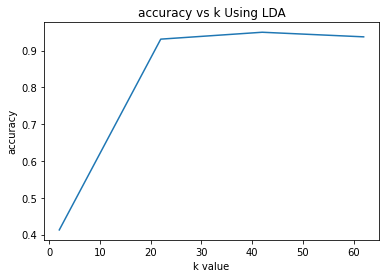

In [39]:
plt.plot(K, accuracy)
plt.xlabel('k value')
plt.ylabel('accuracy') 
plt.title('accuracy vs k Using LDA')
plt.show()

##6. Check for different K Value using PCA

In [40]:
accuracy = []
K = []
for i in range(2, 82, 20):
  K.append(i)
K

[2, 22, 42, 62]

In [41]:
for k in K:
  feature_vec = n_components(k, V)
  # print(feature_vec.shape)
  eigenFace_train = gen_eigenface(feature_vec, dev)
  # print(eigenFace_train.shape)
  projection_train = gen_projection(eigenFace_train, dev)
  # print(projection_train.shape)
  projection_test = gen_projection(eigenFace_train, dev_test)
  # print(projection_test.shape)
  correctlMatch = 0
  for i in range(projection_test.shape[1]):
    predicted = predict(projection_test[:, i], projection_train)
    if(predicted == y_test[i]):
      correctlMatch += 1
  accuracy.append(correctlMatch/projection_test.shape[1])
print(accuracy)

[0.4125, 0.88125, 0.88125, 0.88125]


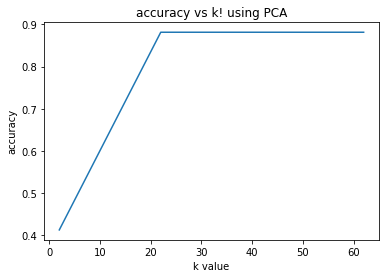

In [42]:
plt.plot(K, accuracy)
plt.xlabel('k value')
plt.ylabel('accuracy') 
plt.title('accuracy vs k! using PCA')
plt.show()

##7. Conclusion
Training using LDA gives higher accuracy as compare to PCA

##8. Using Mahalanobis Distance

In [57]:
accuracy = []
K = []
for i in range(2, 82, 20):
  K.append(i)
K

[2, 22, 42, 62]

In [58]:
from scipy.spatial.distance import mahalanobis
def predictM(d, X):
  # d: projection of testing images
  # print(d.shape)
  # print(X.shape)
  minDist = np.finfo('float').max # initialize with max value
  minClass = -1 # default closest match initialized
  cov = np.dot(X, X.T)
  covI = np.linalg.inv(cov)
  for i in range(X.shape[1]):
    dist = mahalanobis(X[:, i], d, covI)
    if dist < minDist:
      minDist = dist
      minClass = y_train[i]
  return minClass

In [59]:
for k in K:
  # print(k)
  feature_vec = n_components(k, V)
  # print("feature_vec", feature_vec.shape)
  eigenFace_train = gen_eigenface(feature_vec, dev)
  # print(eigenFace_train.shape)
  projection_train = gen_projection(eigenFace_train, dev)
  # print(projection_train.shape)
  M = mean_proj(projection_train)
  # print(M.shape)
  SW = intra_scatter(projection_train)
  # print(SW.shape)
  SB = inter_scatter(projection_train, M)
  # print(SB.shape)
  J = criterion_func(SW, SB)
  # print(J.shape)
  eigVal, eigVec = np.linalg.eig(J)
  idx = np.argsort(eigVal)[::-1] # get the indices in descending order according to data
  eigVal = eigVal[idx] # sort the value
  eigVec = eigVec[:, idx] # sort the vector
  # print(eigVec.shape)
  fisher_faces = fisher_face(eigVec, projection_train)
  # print(fisher_faces.shape)
  projection_test = gen_projection(eigenFace_train, dev_test)
  # print(projection_test.shape)
  PFTI = np.dot(eigVec.T, projection_test)
  # print(PFTI.shape)
  correctlMatch = 0
  for i in range(PFTI.shape[1]):
    predicted = predictM(PFTI[:, i], fisher_faces)
    if(predicted == y_test[i]):
      correctlMatch += 1
  accuracy.append(correctlMatch/projection_test.shape[1])
print(accuracy)

shape of mean of projection (2, 1)
shape of mean of projection (22, 1)
shape of mean of projection (42, 1)
shape of mean of projection (62, 1)
[0.41875, 0.89375, 0.94375, 0.9]


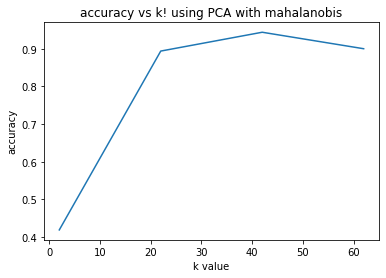

In [60]:
plt.plot(K, accuracy)
plt.xlabel('k value')
plt.ylabel('accuracy') 
plt.title('accuracy vs k! using PCA with mahalanobis')
plt.show()

Nearly similar accuracy we found using Mahalanobis